In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_fashion_mnist import Net, Net2c
import dset_fashion_mnist as dset
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set args
args = dset.get_args()
args.cuda = "True"
args.epochs = 100

# load fashion-mnist dataset
train_loader, test_loader = dset.load_data(args.batch_size, 1, device)

# model
model = Net().to(device)
model.load_state_dict(torch.load('./fashion-mnist.model.pth', map_location=device))
model = model.eval().to(device)
# dset.test(model, test_loader, args)

In [3]:
# FFT
t = lambda x: torch.fft(torch.stack((x, torch.zeros_like(x)),dim=4), 2)
transform_i = modularize(lambda x: torch.ifft(x, 2)[...,0])
band_center = 0.5
band_width_lower = 0.0
band_width_upper = np.Inf
transformer = lambda x: transform_bandpass(x, band_center, band_width_lower, band_width_upper)

# prepend transformation
model_t = TrimModel(model, transform_i)

## attributions on the low- and high-frequency


In [4]:
# mask band
mask = 1 - freq_band(28, band_center, band_width_lower, band_width_upper)
scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'CD': [],
    'InputXGradient': []
}
attr_methods = ['IG', 'DeepLift', 'SHAP', 'CD', 'InputXGradient']

In [5]:
for idx, (im, target) in enumerate(test_loader):
    im = im.to(device)
    im_t = t(im)
    target = target.item()
    
    # attr
    results = get_attributions(im_t, model_t, class_num=target)  
    for i, name in enumerate(attr_methods):
        low_attr = np.sum(fftshift(results[name]) * mask)
        high_attr = np.sum(fftshift(results[name]) * (1-mask))
        scores[name].append(np.array([low_attr, high_attr])) 

    print('\riteration:', idx, end='')
    if idx % 100 == 0:
        pkl.dump(scores, open('scores.pkl', 'wb'))

iteration: 9999

In [14]:
scores['IG'] = np.array(scores['IG'])
scores['DeepLift'] = np.array(scores['DeepLift'])
scores['SHAP'] = np.array(scores['SHAP'])
scores['CD'] = np.array(scores['CD'])
scores['InputXGradient'] = np.array(scores['InputXGradient'])     
pkl.dump(scores, open('scores.pkl', 'wb'))

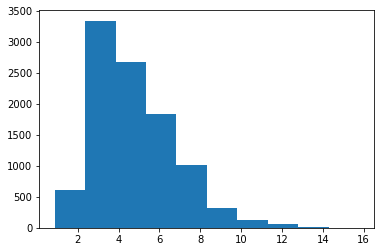

In [17]:
plt.hist(scores['IG'][:,0]/scores['IG'][:,1])
plt.show()

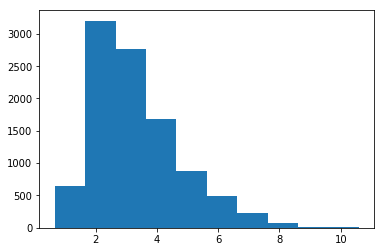

In [18]:
plt.hist(scores['DeepLift'][:,0]/scores['DeepLift'][:,1])
plt.show()

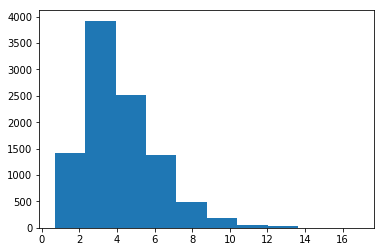

In [19]:
plt.hist(scores['SHAP'][:,0]/scores['SHAP'][:,1])
plt.show()

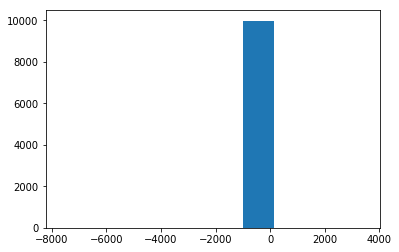

In [20]:
plt.hist(scores['CD'][:,0]/scores['CD'][:,1])
plt.show()

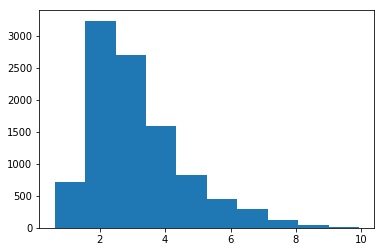

In [21]:
plt.hist(scores['InputXGradient'][:,0]/scores['InputXGradient'][:,1])
plt.show()